In [1]:
import os
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam # this for python 3.10
import math, time
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import shap

Using TensorFlow backend.
e:\anaconda\envs\shapenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
e:\anaconda\envs\shapenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
e:\anaconda\envs\shapenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
e:\anaconda\envs\shapenv\lib\site-packages\tensorflow\python\framework\dtypes.py

If running shap change version variable to 3.7, if not set to anthing else.

In [2]:
from sys import version
versioncheck = version[:3] == '3.7'
versioncheck

True

In [3]:
if versioncheck:
    from keras.optimizers import Adam
else:
    pass

In [4]:
os.chdir('../..')

In [5]:
dataset = pd.read_csv('data/data_nominal_clean.csv', sep=';',  index_col='date',  parse_dates=['date'])

In [6]:
pd.DataFrame(dataset['Gold'])

,Gold
date,
1986-01-02,326.30
1986-01-03,326.75
1986-01-06,328.00
1986-01-07,330.00
1986-01-08,332.60
...,...
2022-12-30,1813.75
2023-01-03,1843.25
2023-01-04,1857.30


lagging gold col

In [7]:
dataset['GoldLag']  = dataset['Gold'].shift(20)

In [8]:
df = dataset[['Gold', 'GoldLag']]
df

,Gold,GoldLag
date,,
1986-01-02,326.30,NaN
1986-01-03,326.75,NaN
1986-01-06,328.00,NaN
1986-01-07,330.00,NaN
1986-01-08,332.60,NaN
...,...,...
2022-12-30,1813.75,1753.50
2023-01-03,1843.25,1803.15
2023-01-04,1857.30,1784.75


In [9]:
df.dropna(inplace=True)
df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Gold,GoldLag
date,,
1986-01-30,358.00,326.30
1986-01-31,350.50,326.75
1986-02-03,347.30,328.00
1986-02-04,338.60,330.00
1986-02-05,337.30,332.60
...,...,...
2022-12-30,1813.75,1753.50
2023-01-03,1843.25,1803.15
2023-01-04,1857.30,1784.75


---
# RNN univariate

In [10]:
X_train, y_train = df['GoldLag'].iloc[:-20].values, df['Gold'].iloc[:-20].values
X_test, y_test = df['GoldLag'].iloc[-20:].values, df['Gold'].iloc[-20:].values

In [11]:
scx = MinMaxScaler(feature_range=(0,1))
scy = MinMaxScaler(feature_range=(0,1))
X_trains = scx.fit_transform(X_train.reshape(-1,1))
y_trains = scy.fit_transform(y_train.reshape(-1,1))

In [12]:
adam = Adam(lr=0.001)

In [13]:
# this is needed for python 3.7 , for keras and tf in python 3.10 comment out this cell
if versioncheck:
    from numpy import newaxis

    X_trains =X_trains[:,:,newaxis]
    y_trains.reshape(1,-1)
else:
    pass

In [18]:
model = Sequential()
model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(X_trains.shape[1],1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "relu"))

model.compile(loss='mse', optimizer=adam, metrics=['mse'])

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 1, 50)             2600      
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 1, 100)            15100     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 100)            0         
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 200)               60200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1) 

In [19]:
history = model.fit(X_trains, y_trains, batch_size=512, epochs=100, verbose=2, use_multiprocessing=True)

Epoch 1/100
 - 1s - loss: 0.0321 - mse: 0.0321
Epoch 2/100
 - 0s - loss: 0.0065 - mse: 0.0065
Epoch 3/100
 - 0s - loss: 0.0049 - mse: 0.0049
Epoch 4/100
 - 0s - loss: 0.0041 - mse: 0.0041
Epoch 5/100
 - 0s - loss: 0.0041 - mse: 0.0041
Epoch 6/100
 - 0s - loss: 0.0040 - mse: 0.0040
Epoch 7/100
 - 0s - loss: 0.0038 - mse: 0.0038
Epoch 8/100
 - 0s - loss: 0.0038 - mse: 0.0038
Epoch 9/100
 - 0s - loss: 0.0037 - mse: 0.0037
Epoch 10/100
 - 0s - loss: 0.0037 - mse: 0.0037
Epoch 11/100
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 12/100
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 13/100
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 14/100
 - 0s - loss: 0.0035 - mse: 0.0035
Epoch 15/100
 - 0s - loss: 0.0035 - mse: 0.0035
Epoch 16/100
 - 0s - loss: 0.0032 - mse: 0.0032
Epoch 17/100
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 18/100
 - 0s - loss: 0.0035 - mse: 0.0035
Epoch 19/100
 - 0s - loss: 0.0032 - mse: 0.0032
Epoch 20/100
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 21/100
 - 0s - loss: 0.0035 - mse: 0.0035
E

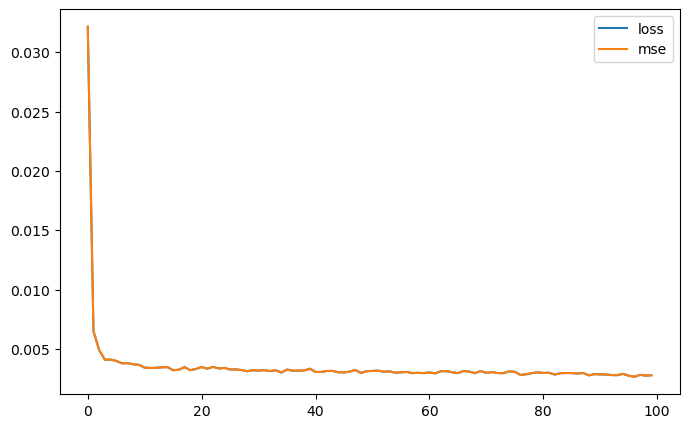

In [20]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [21]:
sctsx = MinMaxScaler(feature_range=(0,1))
sctsx.fit(X_test.reshape(-1,1))
X_tests = sctsx.transform(X_test.reshape(-1,1))

In [22]:
sctsy = MinMaxScaler(feature_range=(0,1))
sctsy.fit(y_test.reshape(-1,1))

MinMaxScaler()

In [23]:
# version check for reshape
if versioncheck:
    X_tests =X_tests[:,:,newaxis]
else:
    pass

In [24]:
fhats = model.predict(X_tests)

In [25]:
hat_inv = sctsy.inverse_transform(fhats)

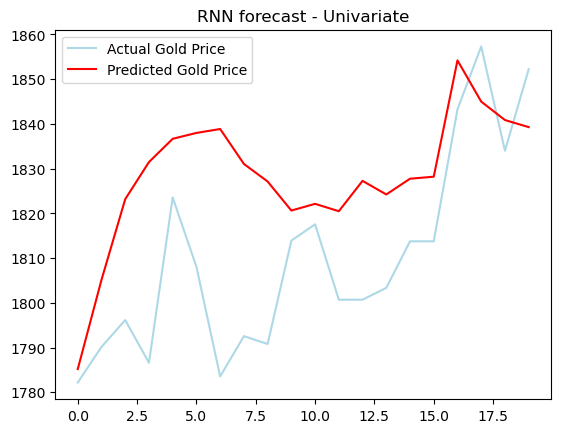

<Figure size 640x480 with 0 Axes>

In [26]:
plt.plot(y_test, color='lightblue', label='Actual Gold Price')
plt.plot(hat_inv, color='red',label='Predicted Gold Price')
plt.title('RNN forecast - Univariate')
plt.legend()
plt.show()
plt.clf()

In [27]:
# metrics
mae_mv = mean_absolute_error(y_test, hat_inv)
mape_uv = mean_absolute_percentage_error(y_test, hat_inv)
mse_uv = mean_squared_error(y_test, hat_inv)
rmse_uv = np.sqrt(mse_uv)

In [28]:
print(f'MAE: {mae_mv}\nMAPE: {mape_uv}\nMSE: {mse_uv}\nRMSE: {rmse_uv}')

MAE: 20.653450927734376
MAPE: 0.011462040678873553
MSE: 619.7006628733583
RMSE: 24.89378763614244


---
# RNN multivariate

In [29]:
dataset[['CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']]  = dataset[['CrudeOil', 'S&P500', 'FTSE250']].shift(20)
dataset

,Gold,CrudeOil,S&P500,FTSE250,GoldLag,CrudeOilLag,S&P500Lag,FTSE250Lag
date,,,,,,,,
1986-01-02,326.30,25.56,209.59,1417.26,NaN,NaN,NaN,NaN
1986-01-03,326.75,26.00,210.88,1424.61,NaN,NaN,NaN,NaN
1986-01-06,328.00,26.53,210.65,1430.96,NaN,NaN,NaN,NaN
1986-01-07,330.00,25.85,213.80,1421.22,NaN,NaN,NaN,NaN
1986-01-08,332.60,25.87,207.97,1408.79,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-12-30,1813.75,80.16,3839.50,18853.00,1753.50,80.48,4080.11,19163.33
2023-01-03,1843.25,76.87,3824.14,19134.34,1803.15,81.06,4076.57,19409.42
2023-01-04,1857.30,72.82,3852.97,19391.07,1784.75,79.86,4071.70,19363.28


In [30]:
df = dataset[['Gold', 'CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']].copy()

In [31]:
df.dropna(inplace=True)
df

,Gold,CrudeOilLag,S&P500Lag,FTSE250Lag
date,,,,
1986-01-30,358.00,25.56,209.59,1417.26
1986-01-31,350.50,26.00,210.88,1424.61
1986-02-03,347.30,26.53,210.65,1430.96
1986-02-04,338.60,25.85,213.80,1421.22
1986-02-05,337.30,25.87,207.97,1408.79
...,...,...,...,...
2022-12-30,1813.75,80.48,4080.11,19163.33
2023-01-03,1843.25,81.06,4076.57,19409.42
2023-01-04,1857.30,79.86,4071.70,19363.28


In [32]:
X_train, y_train = df[['CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']].iloc[:-20].values, df['Gold'].iloc[:-20].values
X_test, y_test = df[['CrudeOilLag', 'S&P500Lag', 'FTSE250Lag']].iloc[-20:].values, df['Gold'].iloc[-20:].values

In [33]:
scx = MinMaxScaler(feature_range=(0,1))
scy = MinMaxScaler(feature_range=(0,1))
X_trains = scx.fit_transform(X_train)
y_trains = scy.fit_transform(y_train.reshape(-1,1))

In [34]:
X_train

array([[   25.56,   209.59,  1417.26],
       [   26.  ,   210.88,  1424.61],
       [   26.53,   210.65,  1430.96],
       ...,
       [   88.14,  3719.89, 18109.61],
       [   92.58,  3770.55, 18341.57],
       [   91.8 ,  3806.8 , 18559.57]])

In [35]:
adam = Adam(lr=0.001)

In [36]:
if versioncheck:
    X_trains =X_trains[:,:,newaxis]
    #y_trains =y_trains[:,:,newaxis]
else:
    pass

In [37]:
model = Sequential()
model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(X_trains.shape[1],1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "relu"))

model.compile(loss='mse', optimizer=adam, metrics=['mse'])

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 3, 50)             2600      
_________________________________________________________________
dropout_13 (Dropout)         (None, 3, 50)             0         
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 3, 100)            15100     
_________________________________________________________________
dropout_14 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 200)               60200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1) 

In [38]:
history = model.fit(X_trains, y_trains, batch_size=512, epochs=100, verbose=2, use_multiprocessing=True)

Epoch 1/100
 - 1s - loss: 0.0486 - mse: 0.0486
Epoch 2/100
 - 0s - loss: 0.0214 - mse: 0.0214
Epoch 3/100
 - 0s - loss: 0.0190 - mse: 0.0190
Epoch 4/100
 - 0s - loss: 0.0174 - mse: 0.0174
Epoch 5/100
 - 0s - loss: 0.0164 - mse: 0.0164
Epoch 6/100
 - 0s - loss: 0.0153 - mse: 0.0153
Epoch 7/100
 - 0s - loss: 0.0146 - mse: 0.0146
Epoch 8/100
 - 0s - loss: 0.0134 - mse: 0.0134
Epoch 9/100
 - 0s - loss: 0.0116 - mse: 0.0116
Epoch 10/100
 - 0s - loss: 0.0113 - mse: 0.0113
Epoch 11/100
 - 0s - loss: 0.0110 - mse: 0.0110
Epoch 12/100
 - 0s - loss: 0.0105 - mse: 0.0105
Epoch 13/100
 - 0s - loss: 0.0098 - mse: 0.0098
Epoch 14/100
 - 0s - loss: 0.0093 - mse: 0.0093
Epoch 15/100
 - 0s - loss: 0.0087 - mse: 0.0087
Epoch 16/100
 - 0s - loss: 0.0086 - mse: 0.0086
Epoch 17/100
 - 0s - loss: 0.0084 - mse: 0.0084
Epoch 18/100
 - 0s - loss: 0.0080 - mse: 0.0080
Epoch 19/100
 - 0s - loss: 0.0080 - mse: 0.0080
Epoch 20/100
 - 0s - loss: 0.0078 - mse: 0.0078
Epoch 21/100
 - 0s - loss: 0.0076 - mse: 0.0076
E

In [39]:
sctsx = MinMaxScaler(feature_range=(0,1))
sctsx.fit(X_test)
X_tests = sctsx.transform(X_test)

In [40]:
sctsy = MinMaxScaler(feature_range=(0,1))
sctsy.fit(y_test.reshape(-1,1))
#ytt = sctsy.transform(y_test.reshape(-1,1))

MinMaxScaler()

In [41]:
if versioncheck:
    X_tests =X_tests[:,:,newaxis]
    #y_trains =y_trains[:,:,newaxis]
else:
    pass

In [42]:
fhats = model.predict(X_tests)

In [43]:
hat_inv = sctsy.inverse_transform(fhats)

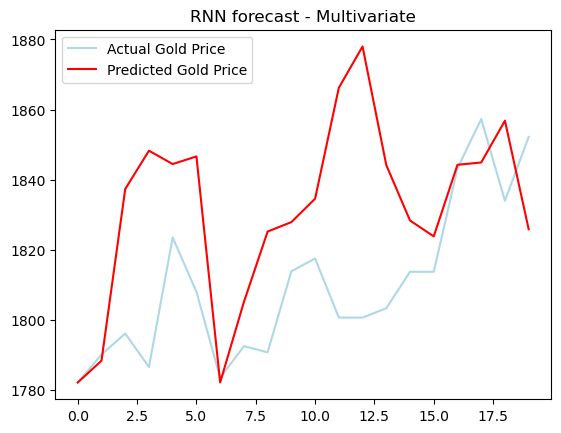

<Figure size 640x480 with 0 Axes>

In [44]:
plt.plot(y_test, color='lightblue', label='Actual Gold Price')
plt.plot(hat_inv, color='red',label='Predicted Gold Price')
plt.title('RNN forecast - Multivariate')
plt.legend()
plt.show()
plt.clf()

In [45]:
# metrics
mae_mv = mean_absolute_error(y_test, hat_inv)
mape_mv = mean_absolute_percentage_error(y_test, hat_inv)
mse_mv = mean_squared_error(y_test, hat_inv)
rmse_mv = np.sqrt(mse_mv)s

In [46]:
print(f'MAE: {mae_mv}\nMAPE: {mape_mv}\nMSE: {mse_mv}\nRMSE: {rmse_mv}')

MAE: 25.719038085937505
MAPE: 0.01423831653428032
MSE: 1143.77058125031
RMSE: 33.81967742676311


---
# Attempt at shap explanations

In [95]:
shap.initjs()
explainermv = shap.DeepExplainer(model, X_trains)

You have provided over 5k background samples! For better performance consider using smaller random sample.


In [96]:
shap_values_mv = explainermv.shap_values(X_tests)

In [110]:
X_tests[0]

array([[0.97722706],
       [0.23991072],
       [0.05023375]])

In [123]:
feats = np.array(dataset.columns)

In [143]:
shap_values_mv[0][0]

array([[ 0.00499716],
       [-0.0025725 ],
       [-0.30050351]])

In [130]:
explainermv.expected_value

array([0.29807884], dtype=float32)

In [144]:
#shap.summary_plot(shap_values_mv, X_tests)
shap.initjs()
shap.force_plot(explainermv.expected_value[0], shap_values_mv[0][0], feature_names=['flet'])

In [136]:
shap.plots.bar(shap_values_mv)

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!